In [21]:
import pandas as pd

In [52]:
df = pd.read_csv("./Input/pesticide_use.csv", encoding = "cp1252")

/tmp/ipykernel_58581/2370551333.py:1: DtypeWarning:

Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.



# Choise of unit = gram per International Dollar

In [53]:
# We are interested to work with this unit. One reason is, this is the only normalized unit of the bunch
# The value_counts() when filtered with this unit, shows just one item for the columns Item and Element.\
# Therefore no other factors
df = df[df["Unit"] == "g/Int$"]

# Continent-wise Descriptive statistics

In [54]:
# We'll do continent-wise analysis
continents_to_filter = ['Africa', 'Asia', 'Europe', 'Northern America', 'Central America', 'South America', 'Oceania']
filtered_df = df[df['Area'].isin(continents_to_filter)]

In [55]:
# We would group by Area, and find the Area's mean Value and sd of the Value
grouped_stats = filtered_df.groupby('Area')['Value'].agg(['mean', 'std'])

In [56]:
grouped_stats["Area"] = grouped_stats.index

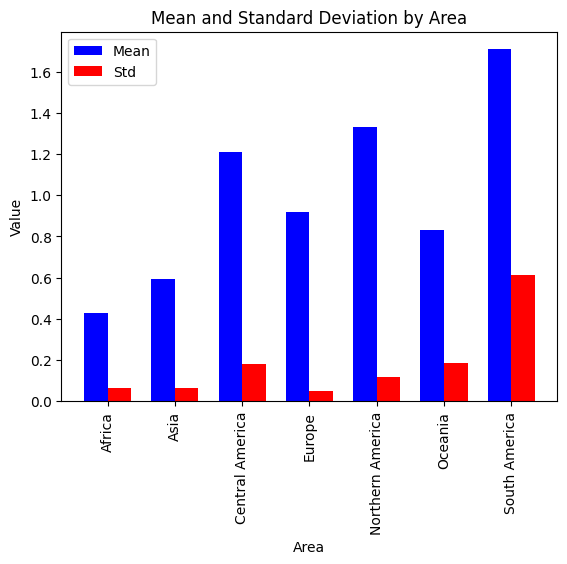

In [58]:
import matplotlib.pyplot as plt
df = grouped_stats

# Plotting grouped bar chart
fig, ax = plt.subplots()

# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars on the x-axis
x = range(len(df))

# Plotting bars for mean
bars1 = ax.bar(x, df['mean'], width=bar_width, label='Mean', color='b')

# Plotting bars for standard deviation
bars2 = ax.bar([p + bar_width for p in x], df['std'], width=bar_width, label='Std', color='r')

# Labeling the x-axis ticks with area names
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(df['Area'], rotation=90)

# Adding labels, title, and legend
ax.set_xlabel('Area')
ax.set_ylabel('Value')
ax.set_title('Mean and Standard Deviation by Area')
ax.legend()

# Show the plot
plt.show()
